## 0. IMPORT LIBRARIES

In [1]:
import numpy as np
from numpy.linalg import pinv, norm, eigvals, matrix_rank
from numpy.random import randint, rand, random_sample

from scipy.linalg import null_space, orth
from scipy.optimize import minimize
from scipy.sparse import diags

import matplotlib.pyplot as plt

from math import inf

from decimal import *
import math

## 1. CORE FUNCTIONS AND DEFINITIONS

In [2]:
def norm_weigh(z, A):
    """
   Function for a matrix-weighted norm (see. [2] page 2)

    Parameters:
        z: a vector from R^n
        A: a symmetric nxn positive-definite matrix

    Returns:
        The semi-norm
    """
    return np.dot(z.T, A@z)

def f(x,c):
    """
        A function f: R^n -> R defined in [1] Assumption 1(i). For the project we chose a l2-norm
        
        Parameters:
            x: a vector from R^n 
            c: a constant for affine shift
        
        Returns:
            l2-norm with affine shift
    """
    return 0.5*norm(x-c)**2


def grad(x):
    """
        Gradient of f
    """
    return x
    

def prox(sig, x, g, lamb):
    """
    Proximal operator for l1- or l2-norm
    
    Parameters:
        sig: prox regularization factor 
        x: vector
        g: indicates whether l1- or l2-norm
        lamb: regularization factor of g
    
    """
    
    if g == 1:
        return np.sign(x)*np.minimum(lamb, np.abs(x))
    elif g == 2:
        return np.maximum(0,1-(sig*lamb)/norm(x))*x


def proj(w, A):
    """"
     Projection onto orthogonal complement of Ker(A) (see [2] p.11)

    Parameters:
        w: vector w  defined in EPAPC and PAPC algorithms ([2] and [1] respectively)
        A: matrix defined in Assumption 1(iv) (see [2] p.3)

    Returns: 
        matrix that represents a projection onto orthogonal complement of Ker(A)
        
    """
    return pinv(A)@A@w

## 2. ALGORITHMS

In [3]:
def EPAPC(A, M, A_block, x, y, tau, sig, g, lamb):
    """
        EPAPC algorithm defined in [2] p.10 

        Parameters: 
            A: a block matrix that consists of linear mappings A_block[i] from Assumption 1(iii) in [2]
            M: a number of block matrices i.e. length of A_block
            A_block: A list that contains linear mappings from Assumption 1(iii) in [2]
            x: stores iterations for x, at the start value x_0 is defined randomly
            y: stores iterations for y, at the start value y_0 is defined randomly
            sig: parameter chosen to satisfy (1.9a) in EPAPC in [2]
            tau: parameter from (0,1) chosen to satisfy (1.9a) in EPAPC in [2]
            g: indicates whether l1- or l2-norm
            lamb: regularization factor of g
        
        Returns: 
            Generates the sequences for x and y from above 
    """
    while True:
        p = x - tau*(grad(x) + A@y)
        w = {}
        for i in range(M):
            w[i] = prox(sig, y[i] + sig*(A_block[i].T)@p, g, lamb)
        w = np.concatenate(tuple(w.values()), axis=0)
        y = proj(w, A)
        x = x - tau*(grad(x) + A@y)
        yield x,y

def PAPC(A, M, A_block, x, y, tau, sig, g, lamb):
    """
        PAPC algorithm defined in [1] p.11 

        Parameters: 
            A: a block matrix that consists of linear mappings A_block[i] from Assumption 1(iii) in [1]
            M: a number of block matrices i.e. length of A_block
            A_block: A list that contains linear mappings from Assumption 1(iii) in [1]
            x: stores iterations for x, at the start value x_0 is defined randomly
            y: stores iterations for y, at the start value y_0 is defined randomly
            sig: parameter chosen to satisfy (2.9a) in PAPC in [1] 
            tau: parameter from (0,1) chosen to satisfy (2.9a) in PAPC in [1]
            g: indicates whether l1- or l2-norm
            lamb: regularization factor of g
        
        Returns: 
            Generates the sequences for x and y from above 
    """
    while True:
        p = x - tau*(grad(x) + A@y)
        w = {}
        for i in range(M):
            w[i] = prox(sig, y[i] + sig*(A_block[i].T)@p, g, lamb)
        w = np.concatenate(tuple(w.values()), axis=0)
        y = w
        x = x - tau*(grad(x) + A@y)
        yield x,y

## 3. FUNCTIONS FOR VISUAL REPRESANTATION

In [4]:
#3. VISUAL REPRESENTATION

def results(A, M, A_block, x0, y0, sig, tau, max_iter = 2000, g=2, gen = EPAPC, lamb = 1):
    """
      This function generates all the values for x and y from EPAPC/PAPC algorithms for the given nubmer of iterations 

        Parameters: 
            A: a block matrix that consists of linear mappings A_block[i] from Assumption 1(iii) in [1] or in [2]
            M: a number of block matrices i.e. length of A_block
            A_block: A list that contains linear mappings from Assumption 1(iii) in [1] or in [2]
            x0: start value for x in the algorthms 
            y0: start value for y in the algorthms 
            sig: parameter chosen to satisfy (2.9a) in PAPC in [1] or (1.9a) in EPAPC in [2]
            tau:  parameter from (0,1) chosen to satisfy (2.9a) in PAPC in [1] or (1.9a) in EPAPC in [2]
            max_iter: number of iterations the algorithms need to perform, default value is set to 2000
            g: indicates whether l1- or l2-norm, default is set to l2-norm 
            gen: indicates whether PAPC or PAPC should be performed, default is set to EPAPC 
            lamb: regularization factor of g, default is set to 1
        
        Returns: 
            u_arr: all the pairs (x^k, y^k) for max_iter iterations 
            u_hat: an approximation of a saddle-point solution 
            max_iter: number of iterations the algorithms need to perform
    """
    GEN = gen(A, M, A_block, x = x0, y = y0, sig = sig, tau = tau, g = g, lamb = lamb)
    k = 0
    u_arr = {}

    ## 4.2. Start iteration
    for u in GEN:

        ### 4.2.2. Save iteration
        u = np.concatenate((u[0],u[1]))
        u_arr[k] = u

        ### 4.2.3. Stop if maximal iteration count is exceeded
        k += 1
        if k > max_iter:
            break
    u_hat = u_arr[max_iter]
    return u_arr, u_hat, max_iter


In [5]:
def sequences(mat, gen, g, start_iter, max_iter, lamb):
    """
        This function computes the approximation of delta 

        Parameters: 
            mat: A tuple that consists of 8 values. The detailed infromation is in sections 4 (fin) and 5 (finavg)
            gen: indicates whether PAPC or PAPC should be performed
            g: indicates whether l1- or l2-norm
            start_iter: number of iteration we start to plot with (on x-axis)
            max_iter: number of iterations the algorithms need to perform
            lamb: regularization factor of g
        Returns:
            u: all the pairs (x^k, y^k) for max_iter iterations 
            norm_m: marix for the weighted norm 
            delta_g: approximation of delta 
            delta_p: given delta (in accordance with the theorem 2.1 in [2])

    """
    A, M, A_block, x0, y0, tau, delta, H = mat
    u_arr, u_hat, max_iter = results(A=A, M=M, A_block=A_block, x0=x0, y0=y0, sig=sig, tau=tau, gen=gen, g=g, max_iter=max_iter, lamb = lamb)
    u = u_arr.copy()
    u_h = u_hat
    norm_m = H
    lis = [ (norm_weigh(u[k+2]-u[k+1], H)/norm_weigh(u_arr[k+1]-u_arr[k], H))**2 for k in range(start_iter,max_iter-1)]
    delta_approx = max(lis)[0][0]
    delta_g = delta
    delta_p = delta_approx
    return u, norm_m, delta_g, delta_p

In [6]:
def plotter_prep(mat=(), gen=EPAPC, g=2, start_iter=2000, max_iter=3000, lamb = 1):
    """
        This function does the preparatory calculations that we need later for the plots. 
        
        Parameters: 
            mat: like in sequences(), necessary to be able to get all the results from that function here
            gen: indicates whether PAPC or PAPC should be performed, default is set to EPAPC 
            g: indicates whether l1- or l2-norm, default is set to l2-norm 
            start_iter: number of iteration we start to plot with (on x-axis)
            max_iter: number of iterations the algorithms need to perform, default value is set to 3000
            lamb: lamb: regularization factor of g, default is set to 1

        Returns: 
            y_axis: Values for y-axis (squared weighted norm of u^{k+1} - u^k)
            y_axis1: Values for y-axis (deltas)
    """
    u = []
    y_axis = []

    a, b, c, d = sequences(mat, gen=gen, g=g, start_iter=start_iter, max_iter=max_iter, lamb = lamb)
    u.append(a)
    norm_m = b
    deltas = c
    deltas_p = d

    getcontext().prec = 30 # This step with Decimal is necessary, as otherwise interprets Python the values as complex numbers with imaginary part = 0
    con0 = Decimal(  deltas_p )
    con1 = Decimal( ((norm_weigh(u[0][start_iter+1]-u[0][start_iter], norm_m))[0][0])**2 )
    con2 = Decimal(1)/(Decimal(1+Decimal(deltas.real)))
    y_axis1 = [con1*(con2**Decimal(k-start_iter)) for k in range(start_iter,max_iter)]
    for k in range(start_iter,max_iter):
        summ = ((norm_weigh(u[0][k+1]-u[0][k], norm_m))[0][0])**2    
        y_axis.append(summ)

    return y_axis, y_axis1

In [7]:
def plotter_compare(mat=(), g=1, start_iter = 0, max_iter=3000, lamb = 1):

    """
        This function plots the results for PAPC and EPAPC simultaneously

        Parameters:
            mat:  like in sequences(), necessary to be able to get all the results from that function here
            g: indicates whether l1- or l2-norm
            start_iter: number of iteration we start to plot with (on x-axis)
            max_iter: number of iterations the algorithms need to perform, default value is set to 3000
            lamb: regularization factor of g
    """

    y_axis, y_axis1 = plotter_prep( mat=mat, gen=EPAPC, g=g, start_iter = start_iter, max_iter=max_iter, lamb = lamb)
    Py_axis, Py_axis1 = plotter_prep(mat=mat, gen=PAPC, g=g, start_iter = start_iter, max_iter=max_iter, lamb = lamb)
    x_axis = [i for i in range(start_iter,max_iter)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

    ax1.set_yscale('log')
    ax1.set_title('EPAPC')
    ax1.plot(x_axis, y_axis,  color = 'red')
    ax1.plot(x_axis, y_axis1,  color = 'green')

    ax2.set_yscale('log')
    ax2.set_title('PAPC')
    ax2.plot(x_axis, Py_axis,  color = 'red')
    ax2.plot(x_axis, Py_axis1,  color = 'green')

    plt.show()

In [8]:
def plotter_single(mat=(), g=1, gen=EPAPC, start_iter = 0, max_iter=3000, lamb = 1):
    """
        This function plots the results of EPAPC or PAPC, depends on gen

        Parameters:
            mat:  like in sequences(), necessary to be able to get all the results from that function here
            g: indicates whether l1- or l2-norm
            gen: indicates whether PAPC or PAPC should be performed, default is set to EPAPC 
            start_iter: number of iteration we start to plot with (on x-axis)
            max_iter: number of iterations the algorithms need to perform, default value is set to 3000
            lamb: regularization factor of g
    """
    
    y_axis, y_axis1= plotter_prep(mat=mat, gen=gen, g=g, start_iter = start_iter, max_iter=max_iter, lamb = lamb)
    x_axis = [i for i in range(start_iter,max_iter)]

    fig, ax1 = plt.subplots(figsize=(10, 10))

    ax1.set_yscale('log')
    if(gen==EPAPC):
        ax1.set_title('EPAPC')
    else: 
        ax1.set_title('PAPC')
    ax1.plot(x_axis, y_axis,  color = 'red')
    ax1.plot(x_axis, y_axis1,  color = 'green')

    plt.show()

## 4. EXAMPLE 1: FINITE DIFFERENCES

In [209]:
sig = 2 
""" Sigma that satisfies (2.9a) in PAPC in [1] or (1.9a) in EPAPC in [2] """

L = 1
""" Lipschitz constant of gradient of f """

my = 1
""" Constant of pointwise quadratic supportability of f at x_hat """

alpha = 2
""" Any constant that is > 1 necessary for Theorem 2.1 in [2] or Theorem 3.1 in [1] """

n = 2**6
""" The dimension of the codomain of A """

M = 1
""" A number of block matrices i.e. length of A_block"""

m_list = [n]
""" A list that contains m_i wie in Assumption 1(iii)[2] """

m = sum(m_list)
""" Sum of elements in m_list, necessary for the linear map A:R^m -> R^n, Ay := \sum_{i=1}^m A_i y_i (s. page 3 in [2])"""

a, b = (-10**(15), 10**(15))
""" Start values that are used to define x_0 and y_0 """

A_block = [np.vstack((diags([-1, 1], [0, 1], shape=(n-1, n)).toarray(), np.zeros((1,n))))]
""" A list that contains linear mappings from Assumption 1(iii) in [1] """

A = np.block([A_block])
""" A block matrix that consists of linear mappings A_block[i] from Assumption 1(iii) in [1] or in [2] """

B = orth(A.T).T
k = B.shape[0]
""" 
Constructing B as a ONB of the orthogonal complement of the null space of script A as the range of script A transposed and then
defining k as the dimension of the orthogonal complement of the null space of script A to
construct B as basis of the sub-vectorspace in the reals to the power of m
"""

x0, y0 = (b-a)*rand(n,1)+a, B.T@((b-a)*rand(k,1)+a)
""" 
Random start values x0 and y0 where
x0 is constructed as a random number in the intervall (a,b) an
y0 is constructed as a random linear combination (with scalars in the intervall (a,b)) of the basis vectors of B.
"""

Norm = norm(A.T@A)
""" Defining the weighted norm used later as in [2] (page 2) """

tau = 1/(sig*Norm*2)
""" Tau chosen to satisfy the equation 1.9a from the EPAPC in [2] given sigma equal 2"""

## 2.2. For theorem
#u_hat = np.concatenate((np.zeros((2,1)), np.zeros((7,1))))

G = (1/sig)*np.identity(m) - tau*((A.T)@A)
"""Matrix like in equation (1.12) from [2] or (3.2) from [1]"""

H = np.block([
    [(1/tau)*np.identity(n), np.zeros((n, m))],
    [np.ones((m, n))       , G               ]
            ])
"""Matrix for the weighted norm. See defintion in equation (2.4) from [2] or (3.6) in [1]"""


lambda_min = min(eigvals((A.T)@A)[np.nonzero(eigvals((A.T)@A))])
"""The smallest nonzero eigenvalue of A^T A"""

delta = min([   (alpha - 1)*tau*sig*(1-tau*L)*lambda_min/alpha, 
                (my*tau*sig*lambda_min)/(alpha*tau*(L**2)+sig*lambda_min)
            ])
"""A positive constant necessary to establish q-linear (global) convergence of u^k-sequence. See equation (2.6), (2.9) from [2]"""

fin = (A, M, A_block, x0, y0, tau, delta, H)
"""A tuple that contains all the values necessary for plotting later"""

'A tuple that contains all the values necessary for plotting later'

In [210]:
A.T

array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [211]:
diags([-1, 1], [0, 1], shape=(n-1, n)).toarray()

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

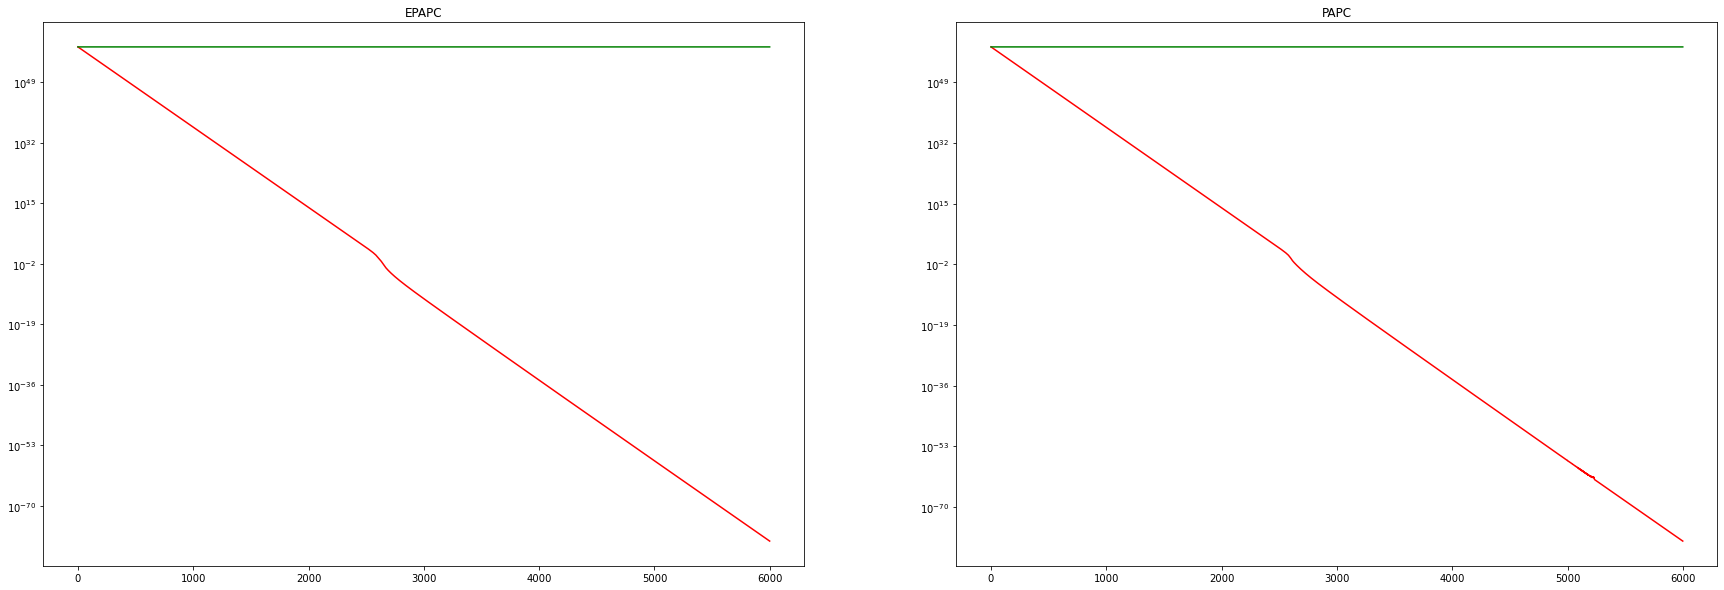

In [212]:
plotter_compare(mat = fin, start_iter=0, max_iter=6000, lamb = 1)

## 5. EXAMPLE 2: FINITE DIFFERENCES AFTER COARSENING

In [222]:
 def V(i):
    s = int(n/(2**i))
    M = np.zeros((s, n))
    for k in range(s):
        M[k,k*2**i:(k+1)*2**i] = 1
    return M

def F(i):
    return np.vstack((diags([-1, 1], [0, 1], shape=(int(n/(2**i))-1, int(n/(2**i)))).toarray(), np.zeros((1,int(n/(2**i))))) )
##add zero row

print(F(2))
def A(i):
    """Linear mapping A_i as in Assumption 1 in [2]"""
    return (F(i) @ V(i)).T



sig =           2 
"""
    Sigma that satisfies (2.9a) in PAPC in [1] or (1.9a) in EPAPC in [2]
"""
L           = 1
"""
    Lipschitz constant of gradient of f
"""
my = 1
"""
    Constant of pointwise quadratic supportability of f at x_hat
"""

alpha = 2
"""
    Any constant that > 1 necessary for Theorem 2.1 in [2] or Theorem 3.1 in [1]"""

j       = 5
n       = 2**j
M       = j

""" A number of block matrices i.e. length of A_block"""

m_list  = [int(n/(2**i)) for i in range(j)]
""" A list that contains m_i wie in Assumption 1(iii)[2] """

m       = sum(m_list)
print(m)
""" Sum of elements in m_list, necessary for the linear map A:R^m -> R^n, Ay := \sum_{i=1}^m A_i y_i (s. page 3 in [2])"""

a, b    = (-10**(15), 10**(15))
""" Start values that are used to define x_0 and y_0 """

A_block = [A(i) for i in range(j)]
"""A list that contains linear mappings from Assumption 1(iii) in [1]"""
A       = np.block([A_block])
print(A.shape)
"A block matrix that consists of linear mappings A_block[i] from Assumption 1(iii) in [1] or in [2]"

B       = orth(A.T).T
Norm    = norm(A.T@A)
""" Defining the weighted norm used later as in [2] (page 2) """


x0, y0      = (b-a)*rand(n,1)+a, np.expand_dims(sum(((b-a)*rand(B.shape[0],1)+a)*B), axis=1)
""" Start values x0 and y0 """

tau             = 1/(sig*Norm*2)
""" Tau chosen to satisfy the equation 1.9a from the EPAPC in [2] given sigma equal 2"""


## 2.2. For theorem
#u_hat = np.concatenate((np.zeros((2,1)), np.zeros((7,1))))

### 2.2.3
G = (1/sig)*np.identity(m) - tau*((A.T)@A)
"""Matrix like in equation (1.12) from [2] or (3.2) from [1]"""

H = np.block([
    [(1/tau)*np.identity(n), np.zeros((n, m))],
    [np.ones((m, n))       , G               ]
            ])
"""Matrix for the weighted norm. See defintion in equation (2.4) from [2] or (3.6) in [1]"""


lambda_min = min(eigvals((A.T)@A)[np.nonzero(eigvals((A.T)@A))])
"""The smallest nonzero eigenvalue of A^T A"""

delta = min([   (alpha - 1)*tau*sig*(1-tau*L)*lambda_min/alpha, 
                (my*tau*sig*lambda_min)/(alpha*tau*(L**2)+sig*lambda_min)
            ])
"""A positive constant necessary to establish q-linear (global) convergence of u^k-sequence. See equation (2.6), (2.9) from [2]"""


finavg = (A, M, A_block, x0, y0, tau, delta, H)
"""A tuple that contains all the values necessary for plotting later"""

[[-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
62
(32, 62)


'A tuple that contains all the values necessary for plotting later'

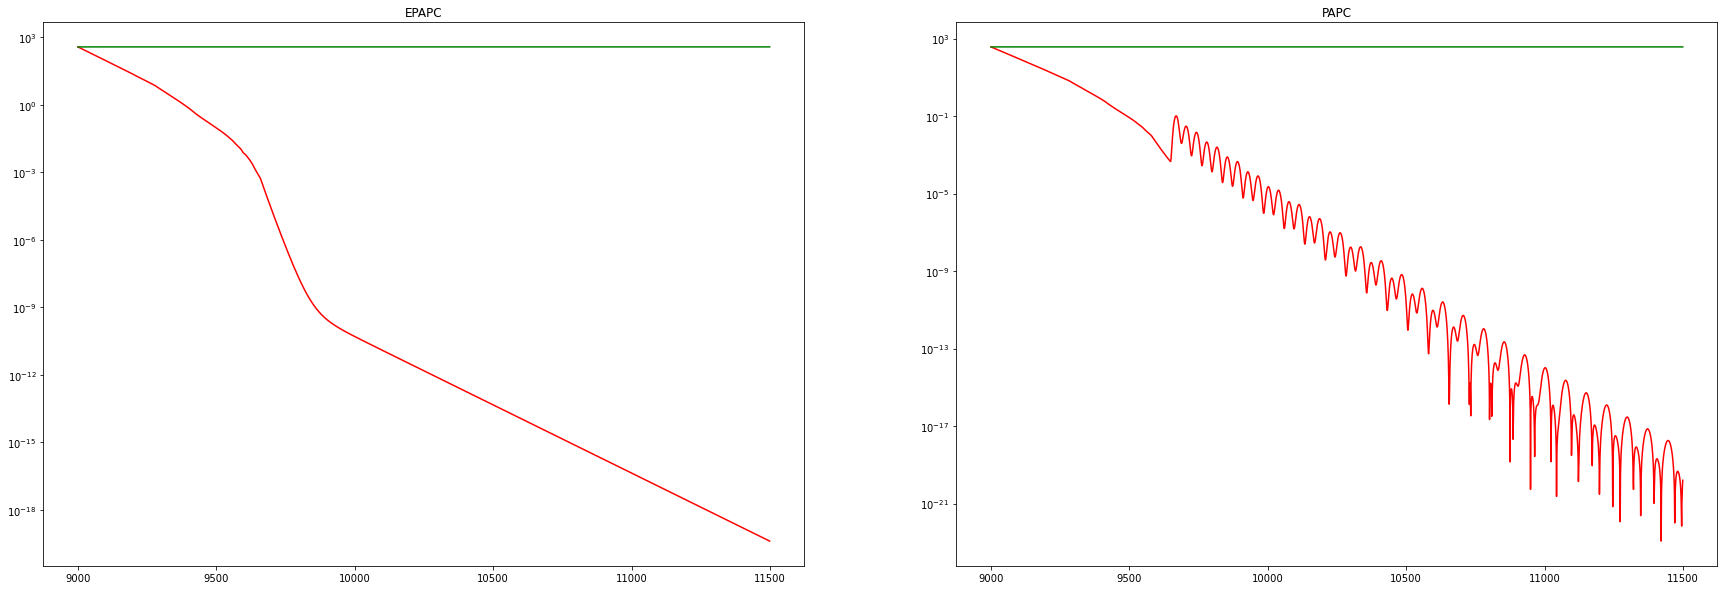

In [223]:
#plotter_single(mat = finavg, gen=EPAPC, start_iter=9000, max_iter=11500, lamb = 1)
#plotter_single(mat = finavg, gen=PAPC, start_iter=9000, max_iter=11500, lamb = 1)
plotter_compare(mat = finavg, start_iter=9000, max_iter=11500, lamb = 1)